In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

# --- Daten (wenige Punkte) ---
t = torch.linspace(0, 2, 10).view(-1, 1)
s = t**3

# Für Autograd nach t:
t = t.clone().detach().requires_grad_(True)

# --- Modell ohne nn.Sequential ---
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=1e-2)

# OPTION: zusätzliche Kollokationspunkte für Physik (typisch PINN)
t_phys = torch.linspace(0, 2, 40).view(-1,1).requires_grad_(True)

lambda_data = 1.0
lambda_phys = 1.0

for epoch in range(3000):
    opt.zero_grad()

    # --- Data loss ---
    pred_s = model(t)
    loss_data = loss_fn(pred_s, s)

    # --- Physics loss (an Kollokationspunkten) ---
    # s'(t) = v, s''(t) = a
    s_phys = model(t_phys)
    v_phys = torch.autograd.grad(
        s_phys, t_phys, grad_outputs=torch.ones_like(s_phys), create_graph=True
    )[0]
    a_phys = torch.autograd.grad(
        v_phys, t_phys, grad_outputs=torch.ones_like(v_phys), create_graph=True
    )[0]

    # Physik: a(t) = 6 t
    loss_phys = loss_fn(a_phys, 6.0 * t_phys)

    # Gesamt
    loss = lambda_data*loss_data + lambda_phys*loss_phys
    loss.backward()
    opt.step()

# Auswertung: dichte Kurve fürs Plotten
with torch.no_grad():
    t_grid = torch.linspace(0, 2, 200).view(-1,1)
    pred_grid = model(t_grid)

print("Final losses -> data:", loss_data.item(), " physics:", loss_phys.item())


/home/lukelo/miniconda3/envs/dl/lib/python3.10/site-packages/torch/autograd/graph.py:829: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Final losses -> data: 7.203822178780683e-07  physics: 7.708997145527974e-05


In [2]:
import matplotlib.pyplot as plt

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

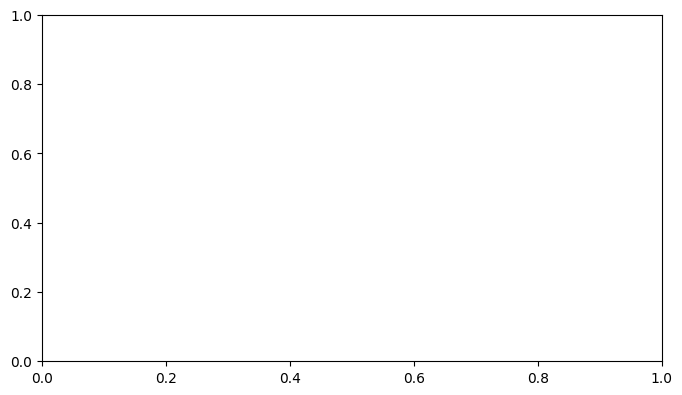

In [4]:
plt.figure(figsize=(8,4.5))
plt.scatter(t, s)